# COMP90051 Workshop 9
## Bayesian Regression
***

In this worksheet, we'll revisit linear regression from a Bayesian perspective. 
We'll build on the standard frequentist approach to linear regression (see Worksheet 3), which assumes a conditional model for the response of the form: 

$$
y_i | \mathbf{x}_i \sim \operatorname{Normal}[\mathbf{x}_i^\top \mathbf{w}, \sigma^2], \quad \forall i \in \{1, \ldots, n\}
$$

where $\mathbf{x}_i \in \mathbb{R}^{d}$ is a vector of predictors (prepended with a constant predictor to incorporate a bias term), $\mathbf{w} \in \mathbb{R}^{d}$ is an unknown weight vector and $\sigma^2$ is a known constant variance.

Working from a Bayesian perspective, we'll treat the unknown weight vector $\mathbf{w}$ as a _random variable_ and specify a prior distribution that encodes our belief about $\mathbf{w}$ before observing any data.
We'll then apply Bayesian inference to update our belief about $\mathbf{w}$ after observing data, and to make predictions using _all settings of the weights_ according to their posterior probabilities.

In [1]:
import numpy as np
import scipy as sp
import matplotlib.pyplot as plt
plt.rcParams['figure.dpi'] = 108
np.random.seed(1)

from sklearn.preprocessing import PolynomialFeatures, StandardScaler
from sklearn.linear_model import BayesianRidge

### 1. Regression data set
Let's generate a small synthetic data set in 1D according to the following model:

$$
\newcommand\ys{\mathbf{y}}
\newcommand\xs{\mathbf{x}}
\newcommand\Xs{\mathbf{X}}
\newcommand\ws{\mathbf{w}}
\newcommand\Vs{\mathbf{V}}
\newcommand\Is{\mathbf{I}}
\begin{align*}
x_i &\sim \mathrm{Uniform}[0,1] \\
y_i | x_i, \sigma^2 &\sim \mathrm{Normal}\!\left[5\left(x - \frac{1}{2}\right)^2, \sigma^2 \right]
\end{align*}
$$

By focussing on the 1D case, it'll be straightforward to visualise the results.
We'll keep the data set small, since Bayesian approaches are particularly useful when limited data is available.

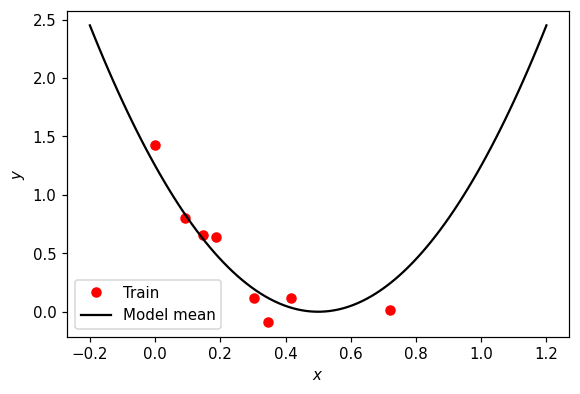

In [2]:
n_instances = 8
sigma = 0.1 # keep this small: don't want too much noise

# generate data matrix with rows as instances
X = np.random.uniform(size=(n_instances,1))

# generate the target response values using the quadratic function
# and additive noise
Y = np.random.normal(loc=5*(X - 0.5)**2, scale=sigma, size=(n_instances,1)).ravel()

# plot the training data
plt.plot(X, Y, 'ro', label='Train')

# and plot the true function (without noise)
X_test = np.linspace(-0.2, 1.2, 100)
X_test = X_test[:,np.newaxis]
Y_test_gold = 5*(X_test - 0.5)**2 
plt.plot(X_test, Y_test_gold, 'k', label='Model mean')
plt.legend()
plt.xlabel('$x$')
plt.ylabel('$y$')
plt.show()

#### Polynomial basis functions
Since the relationship between $y$ and $x$ is non-linear, we'll apply polynomial basis expansion to degree $k$.
Specifically, we replace the original data matrix $\mathbf{X}$ by the transformed matrix

$$
\mathbf{\Phi} = \begin{bmatrix}
    1 & x_1 & x_1^2 & \ldots & x_1^k \\
    1 & x_2 & x_2^2 & \ldots & x_2^k \\
    \vdots & \vdots & \vdots & \ddots & \vdots \\
    1 & x_n & x_n^2 & \ldots & x_n^k \\
\end{bmatrix}.
$$

Note that we're including a column of ones to incorporate a bias term.

The function below is a wrapper around `sklearn.preprocessing.PolynomialFeatures`, which implements the above transformation on a train/test set.

In [3]:
def polynomial_features(X_train, X_test, degree, include_bias=True):
    """
    Augments data matrices X_train and X_test with polynomial features
    """
    poly = PolynomialFeatures(degree=degree, include_bias=include_bias)
    
    Phi_train = poly.fit_transform(X_train)
    Phi_test = poly.fit_transform(X_test)
    
    return Phi_train, Phi_test
    
Phi, Phi_test = polynomial_features(X, X_test, 9)

***
**Discussion question**: How does this basis trick relate to kernel methods?

_Answer_: Polynomial basis expansion is an example of a nonlinear mapping $\Phi: \mathcal{X} \rightarrow \mathcal{F}$ from the original space $\mathcal{X}$ to a higher dimensional space $\mathcal{F}$ (assuming $k > 1$). 
In the code block above, we explicitly apply the mapping $\Phi$—i.e. we compute the feature vectors in the higher dimensional space $\mathcal{F}$.
In contrast, if we were to use kernel methods, we'd be able to operate in the higher dimensional space $\mathcal{F}$ _implicitly_, without ever needing to apply the mapping $\Phi$. 
Instead we would rely on a kernel function $K(x,x') = \langle \Phi(x), \Phi(x') \rangle$, which typically allows us to compute inner products in the higher dimensional space $\mathcal{F}$ efficiently.
This is particularly useful when $\mathcal{F}$ is very high-dimensional—perhaps even infinite-dimensional.
***

### 2. Bayesian regression with known variance

Let's begin with a quick recap of the model introduced in lectures. 
As mentioned in the intro, the likelihood is identical to the one used in standard frequentist linear regression.
What's new is the prior on the weight vector $\ws$, which is assumed to be normal with mean zero and isotropic variance $\gamma^2$:

$$
\begin{align*}
\ws | \gamma &\sim \operatorname{Normal}\!\left[\mathbf{0}, \gamma^2 \mathbf{I}_{d}\right] \\
y_i | \xs_i, \ws, \sigma &\sim \operatorname{Normal}\!\left[\xs_i^\top \ws, \sigma^2\right] & \forall i \in \{1,\ldots,n\}
\end{align*}
$$

By setting the prior mean to zero and choosing a small $\gamma^2$, we are effectively penalising weight vectors with a large $L_2$ norm.

Given this model, the next step is to solve for the posterior over $\ws$

$$
\begin{align*}
p(\ws | \Xs, \ys, \sigma, \gamma) 
= \frac{p(\ys | \Xs, \ws, \sigma) p(\ws | \gamma)}{p(\ys | \Xs, \sigma)} 
= \frac{\prod_{i=1}^n p(y_i | \xs_i, \ws, \sigma) p(\ws | \gamma)}{\int_{\ws} d\ws\prod_{i=1}^n p(y_i | \xs_i, \ws, \sigma) p(\ws | \gamma)} 
\end{align*}
$$

where $\Xs \in \mathbb{R}^{n \times d}$ is a matrix of observed predictors and $\ys \in \mathbb{R}^{n}$ is the corresponding vector of observed responses.

In lectures, we derived the following solution:

$$
\ws | \Xs, \ys, \sigma, \gamma \sim \operatorname{Normal}[\ws_N, \mathbf{V}_N]
$$

where $\Vs_N = \sigma^2 \left( \Xs^\top \Xs + \frac{\sigma^2}{\gamma^2} \Is_{d} \right)^{-1}$ and $\ws_N = \frac{1}{\sigma^2} \Vs_N \Xs^\top \ys$.

***
**Exercise:** Complete the function below to compute the posterior mean $\ws_N$ and covariance matrix $\Vs_N$ for the weights based on the expression above.

_Hints:_
* _the NumPy `@` operator represents matrix multiplication_
* _`np.linalg.inv` can be used to compute the matrix inverse_
* _`np.identity` or `np.eye` can be used to generate an identity matrix_
***

In [4]:
def compute_posterior_params(X, Y, sigma, gamma):
    """
    Compute the parameters (mean and covariance) for the posterior over the weights
    
    Parameters
    ----------
    X : numpy array, shape (n_instances, n_features)
        feature matrix
    Y : numpy array, shape (n_instances,)
        target class labels relative to X
    sigma : float
        positive scale parameter for y
    gamma : float
        positive scale parameter for w_i
    
    Returns
    -------
    The following items in a tuple:
    w_N : numpy array, shape (n_features,)
        mean parameter
    V_N : numpy array, shape (n_features, n_features)
        covariance parameter
    """
    V_N = sigma**2 * np.linalg.inv(X.T @ X + (sigma/gamma)**2 * np.identity(X.shape[1])) # fill in
    w_N = np.ravel(1/sigma**2 * V_N @ X.T @ Y) # fill in
    
    return w_N, V_N

In [5]:
gamma = 10 # larger implies more permissive, i.e. a more diffuse prior
w_N, V_N = compute_posterior_params(Phi, Y, sigma, gamma)

Let's plot the prior and posterior over $\mathbf{w}$ to see how they differ. 
Since $\mathbf{w}$ is $d$-dimensional, we can only visualise the posterior over a couple of components at a time.
Here we look at $p(w_1, w_2|\mathbf{X}, \mathbf{y}, \sigma, \gamma)$.

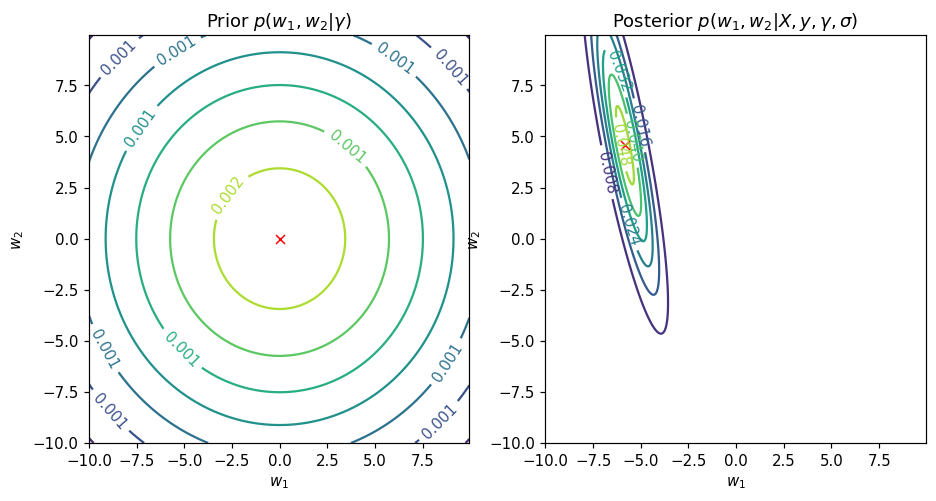

In [6]:
# set up a 2d plot mesh
w1, w2 = np.mgrid[-10:10:.05, -10:10:.05]
grid = np.c_[w1.ravel(), w2.ravel()]

# which weights do we want to see?
i = 1
j = 2

fig = plt.figure(figsize=(10,5))
# plot a bivariate normal for the prior
ax = fig.add_subplot(121)
p_w = sp.stats.multivariate_normal.pdf(grid, mean=np.zeros(2), cov=gamma**2 * np.identity(2))
CS = ax.contour(w1, w2, p_w.reshape(w1.shape))
plt.clabel(CS, inline=1, fontsize=10)
ax.plot(0, 0, 'rx') # add prior mean
plt.xlabel('$w_1$')
plt.ylabel('$w_2$')
plt.title('Prior $p(w_1, w_2|\gamma)$')

# plot a bivariate normal for the posterior
ax = fig.add_subplot(122)
mean = np.array([w_N[i],w_N[j]])
cov = np.vstack([[V_N[i,i], V_N[i,j]], [V_N[j,i], V_N[j,j]]])
p_w = sp.stats.multivariate_normal.pdf(grid, mean=mean, cov=cov)
CS = ax.contour(w1, w2, p_w.reshape(w1.shape))
plt.clabel(CS, inline=1, fontsize=10)
ax.plot(w_N[i], w_N[j], 'rx') # add posterior mean
plt.xlabel('$w_1$')
plt.ylabel('$w_2$')
plt.title('Posterior $p(w_1, w_2|X,y,\gamma,\sigma)$')
plt.show()

***
**Discussion question**: Can you explain why the prior and the posterior are so different? How is this related to the dataset? *You may like to change the parameter indices from 0,1 to other pairs to get a better idea of the full posterior.*

_Answer:_
The prior on $\ws$ is relatively weak, so we expect the likelihood to dominate. 
This explains why the posterior over $\ws$ significantly diverges from the prior.
***

### 3. Making predictions

We've seen how to compute the posterior of the unknown weight vector $\ws$. 
But how can we use the posterior to make a prediction for a new test instance $\xs_*$?
The proper Bayesian approach is to average over the predictions of all possible models, weighted by their posterior probability:

$$
\underbrace{p(y_* | \xs_*, \Xs, \ys, \sigma^2, \gamma^2)}_{\text{posterior predictive}} = \int \underbrace{p(y_*|\xs_*, \ws, \sigma^2)}_{\text{likelihood}} \underbrace{p(\ws| \Xs, \ys, \gamma^2)}_{\text{posterior}} \, \mathrm{d} \ws
$$

When we do this, we get a new distribution over the response called the _posterior predictive_ which incorporates the uncertainty in $\ws$.
Unfortunately, it's not always possible to obtain an expression for the posterior predictive distribution in closed form. 
In these circumstances, we can obtain an approximation based on sampling:

$$\hat{p}(y_* | \xs_*, \Xs, \ys, \sigma^2, \gamma^2) = \frac{1}{S} \sum_{s = 1}^{S} \mathbb{1}[y_* = y_s]$$ 

where each sample $y_s$ is obtained as follows:

1. $\ws_s$ is drawn from the posterior: $p(\ws | \Xs, \ys, \gamma^2) = \operatorname{Normal}[\ws; \ws_N, \mathbf{V}_N]$
1. $y_s$ is drawn from the likelihood conditioned on $\ws = \ws_s$: $p(y_s | \xs_*, \ws_s, \sigma^2) = \operatorname{Normal}[y_s; \xs_*^\top \ws_s, \sigma^2]$

***
**Exercise:** Complete the inner loop in the code block below to draw a sample from the posterior predictive distribution for all instances in the test set.
***

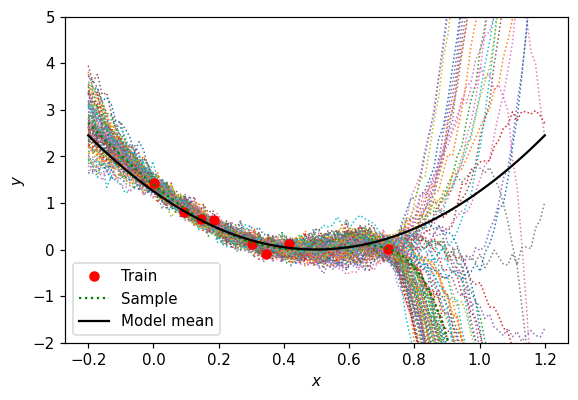

In [7]:
# Generate samples from the posterior predictive
n_samples = 100
for s in range(n_samples):
    # Draw weight vector from the posterior
    w_s = np.random.multivariate_normal(w_N, V_N, 1).ravel() # fill in
    # Compute predictive mean for all test instances simultaneously given 
    # w = w_s
    mu = Phi_test @ w_s
    # Draw responses for all test instances simultaneously given w = w_s
    y_s = np.random.normal(mu, sigma) # fill in
    
    # Plot the responses for all test instances
    p = plt.plot(X_test.ravel(), y_s, ':', lw=1)

plt.plot(X, Y, 'ro', label='Train')
plt.plot(X_test, Phi_test @ w_N, 'g:', label='Sample')
plt.plot(X_test.ravel(), Y_test_gold, 'k', label='Model mean')

plt.ylim(-2, 5)
plt.xlabel('$x$')
plt.ylabel('$y$')
plt.legend()
plt.show()

It's interesting to see what happens near the data points in the training set, and away from them.
We'll come back to this later.

But first, let's return to the problem of computing the posterior predictive distribution. 
Since our model is simple (and the prior is conjugate to the likelihood), we don't need to resort to sampling. 
We can evaluate the posterior predictive distribution analytically, to obtain the following solution:

$$
\begin{gather}
y_{*} | \xs_*, \Xs, \ys, \sigma^2, \gamma^2 \sim \operatorname{Normal}\!\left[\xs_{*}^\top \ws_N, \sigma^2_N(\xs_{*})\right] \\
\text{where} \quad \sigma^2_N(\xs_{*}) = \sigma^2 + \xs_{*}^\top \Vs_N \xs_{*}
\end{gather}
$$

Note that the predictive mean is a simple application of the posterior mean to the data point, but the predictive variance is a bit more complicated. 

***
**Exercise:** Complete the functions below to evaluate the predictive mean $\xs_{*}^\top \ws_N$ and predictive standard deviation $\sigma_N(\mathbf{x}_{*})$ for a collection of test instances. 
Then run the following code block to plot the results.
***

In [8]:
def predictive_mean(X, w):
    """
    Compute the predictive mean for the response, given X and w
    
    Parameters
    ----------
    X : numpy array, shape (n_instances, n_features)
        feature matrix
    w : numpy array, shape (n_features,)
        weights vector
    
    Returns
    -------
    Y_mean : numpy array, shape: (n_instances,)
        predictive mean for each instance in X
    """
    # your code here #
    return np.dot(X, w)

def predictive_std(X, V_N, sigma):
    """
    Compute the predictive standard deviation for the response, given X, V_N and sigma
    
    Parameters
    ----------
    X : numpy array, shape (n_instances, n_features)
        feature matrix
    V_N : numpy array, shape: (n_features, n_features)
        covariance parameter
    
    Returns
    -------
    std : numpy array, shape (n_instances,)
        predictive standard deviation for each instance in X
    """
    # your code here #
    return np.sqrt(sigma**2 + np.sum(X * (X @ V_N), axis=1))

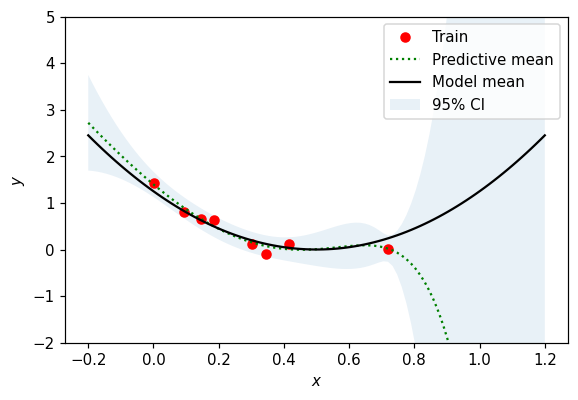

In [9]:
Y_test_mean = predictive_mean(Phi_test, w_N)
Y_test_std = predictive_std(Phi_test, V_N, sigma)

plt.plot(X, Y, 'ro', label='Train')
plt.fill_between(X_test.ravel(), Y_test_mean + 2*Y_test_std, Y_test_mean - 2*Y_test_std, 
                 alpha=0.1, label='95% CI')
plt.plot(X_test.ravel(), Y_test_mean, 'g:', label='Predictive mean')
plt.plot(X_test.ravel(), Y_test_gold, 'k', label='Model mean')

plt.ylim(-2, 5)
plt.xlabel('$x$')
plt.ylabel('$y$')
plt.legend()
plt.show()

***
**Discussion questions**: 

1. How does the exact plot of predictive uncertainty compare to the sample-based one? How does the uncertainty change relative to the distance from training points? Can you explain why?

2. Is a 9th degree polynomial a good choice for this problem? Based on the results above, would you recommend this model, or make a different choice?

3. How does the setting of `gamma` affect the fit? How about the number of instances in the training set? Try some other values and see what happens.

**Answers**
1. The plots are in good agreement. We'd expect 95\% of the samples to fall within the 95\% Bayesian credible interval depicted in the exact plot. The uncertainty increases further from the training points. This effect mainly comes from the uncertainty in the weights.

2. A 9th degree polynomial results in a model that is overly expressive for such a small data set (i.e. it's susceptible to overfitting). We consider lower degree polynomial features in the next section.

3. `gamma` controls the spread of the prior distribution on $\ws$ about the mean. If we set `gamma` to be very small (say 0.1), then the prior will be highly concentrated at $\ws = 0$ and we'll need to observe a lot of data in debree to shift the posterior away from $\ws = 0$.
***

### 4. Bayesian model selection
In this section, we'll revisit the assumption of using 9th degree polynomial features. 
To do this, we'll evaluate competing models using the _model evidence_.
When applied to our regression model, the model evidence can be expressed as follows:

$$
p(\ys|\Xs, \sigma, \gamma) = \int p(\ys | \Xs, \sigma, \gamma, \ws) p(\ws) \, \mathrm{d} \ws.
$$

In words, we compute the likelihood conditioned on the model, and marginalise out the model parameters with respect to their prior distributions (see Sec 3.4 of Bishop).

Since our model is relatively simple, we can evaluate the evidence in closed form. 
We have

$$
\log p(\ys|\Xs, \sigma, \gamma) = - (d+1) \log \gamma - n \log \sigma - E(\ws_N) - \frac{1}{2} \log |\Vs_N^{-1}| - \frac{n}{2} \log 2\pi
$$

where $E(\ws_N) = \frac{1}{2 \sigma^2} \|\ys - \Xs \ws_N \|_2^2 + \frac{1}{2 \gamma^2} |\ws_N|_2^2$.

In the code block below we implement a function that computes the log-evidence for a given posterior mean $\ws_N$, training data $\Xs$, $\ys$ and variance parameters $\sigma$ and $\gamma$.

In [10]:
def compute_evidence(w_N, X, Y, sigma, gamma):
    n_instances, n_features = X.shape
    alpha, beta = 1/gamma**2, 1/sigma**2
    rss = np.sum((Y - np.dot(X, w_N))**2)
    wpen = np.dot(w_N, w_N)
    E = beta/2 * rss + alpha/2 * wpen
    A = alpha * np.identity(n_features) + beta * X.T @ X
    lE = n_features/2 * np.log(alpha) + n_instances/2 * np.log(beta) - E \
        - 0.5 * np.log(np.linalg.det(A)) - n_instances/2 * np.log(2 * np.pi)
    # return both the evidence, and the RSS term (the raw quality of fit)
    return {'logEvidence': lE, 'RSS': rss}

# what's the evidence for our 9th degree model?
compute_evidence(w_N, Phi, Y, sigma, gamma)

{'logEvidence': -7.210639596237662, 'RSS': 0.07104621847390613}

So what happens if we use lower degree polynomial features, e.g., 3rd degree polynomial features?

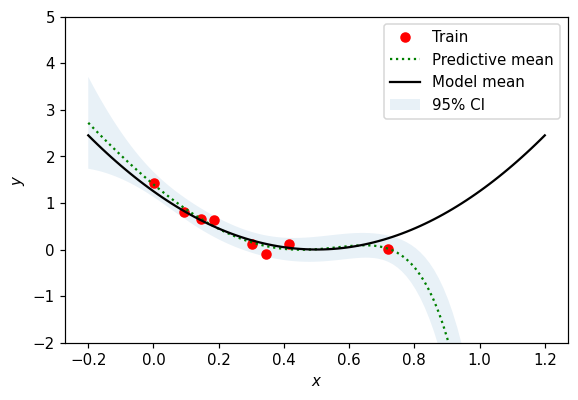

In [11]:
Phi_3, Phi_3_test = polynomial_features(X, X_test, 3)

w_N_3, V_N_3 = compute_posterior_params(Phi_3, Y, sigma, gamma)
Y_test = predictive_mean(Phi_3_test, w_N_3)
Y_test_std = predictive_std(Phi_3_test, V_N_3, sigma)
    
plt.plot(X, Y, 'ro', label='Train')
plt.fill_between(X_test.ravel(), Y_test_mean + 2*Y_test_std, Y_test_mean - 2*Y_test_std, alpha=0.1, label='95% CI')
plt.plot(X_test.ravel(), Y_test_mean, 'g:', label='Predictive mean')
plt.plot(X_test.ravel(), Y_test_gold, 'k', label='Model mean')

plt.ylim(-2,5)
plt.xlabel('$x$')
plt.ylabel('$y$')
plt.legend()
plt.show()

***
**Discussion**: Does that look like a better fit to you? Consider both the interval $[0,1]$ near the training points, and those outside this range.

_Answer:_ The fit is not too different near the training points, at least in terms of the predictive mean. However, the model extrapolates poorly for $x > 0.8$ and is overly confident (the model mean is not within the 95\% Bayesian credible interval).
***

Let's see what the *evidence* says, and compare this to the above result:

In [12]:
compute_evidence(w_N_3, Phi_3, Y, sigma, gamma)

{'logEvidence': -6.6431625493191, 'RSS': 0.07888629421199209}

The RSS has barely changed, but the evidence is much higher. We can look at various polynomial degrees to see which has the best *evidence* to perform Bayesian model selection: 

In [13]:
k_range = np.arange(1, 11)
logEvidence = []
RSS = []
for k in k_range:
    Phi_k, Phi_k_test = polynomial_features(X, X_test, k)
    w_N_k, V_N_k = compute_posterior_params(Phi_k, Y, sigma, gamma)
    result = compute_evidence(w_N_k, Phi_k, Y, sigma, gamma)
    print('Degree {}. Log evidence {}. RSS {}.'.format(k, result['logEvidence'], result['RSS']))
    logEvidence.append(result['logEvidence'])
    RSS.append(result['RSS'])

Degree 1. Log evidence -29.39686607350171. RSS 0.6141638621964031.
Degree 2. Log evidence -5.7484162006696975. RSS 0.08259643223393959.
Degree 3. Log evidence -6.6431625493191. RSS 0.07888629421199209.
Degree 4. Log evidence -6.984455678318592. RSS 0.07653415360637944.
Degree 5. Log evidence -7.122658176161316. RSS 0.07462253729433699.
Degree 6. Log evidence -7.178029861618233. RSS 0.07313020707337617.
Degree 7. Log evidence -7.199556191663649. RSS 0.07209367222456221.
Degree 8. Log evidence -7.207664767336131. RSS 0.07143667429261118.
Degree 9. Log evidence -7.210639596237662. RSS 0.07104621847390613.
Degree 10. Log evidence -7.2117125959468105. RSS 0.07082434587879342.


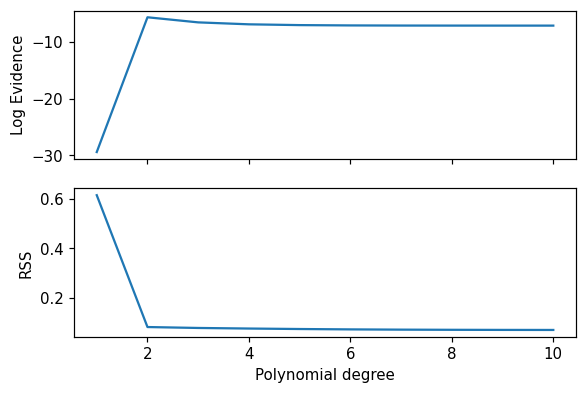

In [14]:
#plot the above log evidence values against the polynomial degree
ax1 = plt.subplot(211)
ax1.plot(k_range, logEvidence)
plt.setp(ax1.get_xticklabels(), visible=False)
plt.ylabel('Log Evidence')

ax2 = plt.subplot(212, sharex=ax1)
ax2.plot(k_range, RSS)
plt.xlabel('Polynomial degree')
plt.ylabel('RSS')
plt.show()

***
**Discussion**: So which model class will be chosen? Is this a reasonable situation? 

_Answer:_ 
We choose the model with the 2nd degree polynomial features, as it maximises the evidence.
This is reasonable, as the original data was generated by applying random noise to a 2nd degree polynomial.
***

### Bonus: Bayesian regression with unknown variance (optional)

In real settings, the variance for $y$, $\sigma^2$ is unknown.
It's possible to account for this by putting the following prior on $\sigma^{2}$:
$$
\sigma^{-2} \sim \textrm{Gamma}(\alpha_1, \alpha_2)
$$
where $\alpha_1, \alpha_2 > 0$ are hyperparameters.

We can also put a prior over the variance for the weights, $\gamma^2$:
$$
\gamma^{-2} \sim \textrm{Gamma}(\lambda_1, \lambda_2)
$$
where $\lambda_1, \lambda_2 > 0$ are hyperparameters.

This model for regression (with the additional priors over $\gamma$ and $\sigma$) is implemented in `sklearn.linear_models.BayesianRidge`.

***
**Exercise**: Apply `BayesianRidge` to the training data (with the polynomial basis expansion) and compare the results to our simpler model.
What happens if the value of $\sigma$ used in our model deviates from the true value used to generate the data?
Is `BayesianRidge` more robust in this case?
***

In [15]:
reg = BayesianRidge(compute_score=True, fit_intercept=False).fit(Phi, Y)

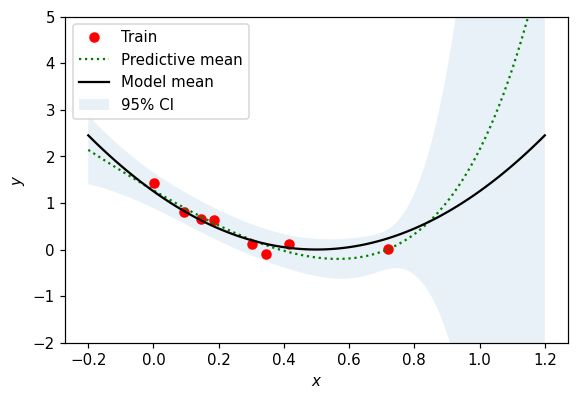

In [16]:
Y_test_mean, Y_test_std = reg.predict(Phi_test, return_std=True)

plt.plot(X, Y, 'ro', label='Train')
plt.fill_between(X_test.ravel(), Y_test_mean + 2*Y_test_std, Y_test_mean - 2*Y_test_std, alpha=0.1, label='95% CI')
plt.plot(X_test, Y_test_mean, 'g:', label='Predictive mean')
plt.plot(X_test, Y_test_gold, 'k', label='Model mean')

plt.ylim(-2,5)
plt.xlabel('$x$')
plt.ylabel('$y$')
plt.legend()
plt.show()